In [1]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=1

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=1


In [2]:
import os
import sys
from copy import deepcopy
import json
import logging
import warnings
import argparse

project_dir = os.path.dirname(os.getcwd())
print(project_dir)
sys.path.append(project_dir)

import depth_pro
import diffusers
from diffusers import DDIMScheduler, MarigoldDepthPipeline
import numpy as np
from PIL import Image
import torch
from torchvision.transforms import ToPILImage, ToTensor, Normalize
from training.dataset.transforms import ComposeAPI, NormalizeAPI
from tqdm import tqdm

from dataset.collate_fn import collate_fn
from dataset.mini_dataset import MiniDataset

/home/guests/tuna_gurbuz/prototype


/home/guests/tuna_gurbuz/miniforge3/envs/trainenv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


DATASET IMAGE

In [3]:
# Dataset
object_labels = [13, 15, 16]
len_video = 1
input_image_size = 512
batch_size = 1
shuffle = False
mean = [0.3551, 0.3500, 0.3469]
std = [0.2921, 0.2716, 0.2742]
transforms = [ComposeAPI([NormalizeAPI(mean=mean, std=std, v2=True)])]
revert_mean=[-.3551/.2921, -.3500/.2716, -.3469/.2742]
revert_std=[1/.2921, 1/.2716, 1/.2742]
revert_transform = Normalize(mean=revert_mean, std=revert_std)
test_dataset = MiniDataset('over_train',
                           num_frames=len_video,
                           input_image_size=input_image_size,
                           object_labels=object_labels,
                           transforms=transforms,
                           collate_fn=collate_fn,
                           batch_size=batch_size,
                           shuffle=shuffle,
                           get_seg_mask=True)
print(f'Lenght of the dataset! {len(test_dataset)}')

Loading the take 001_PKA!



5683it [00:03, 1861.32it/s]


Lenght of the dataset! 17049


File name: /home/polyaxon-data/data1/MM-OR_processed/001_PKA/colorimage/camera01_colorimage-003662.jpg


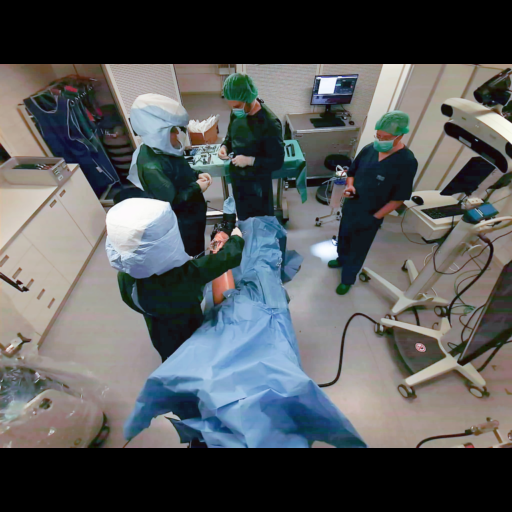

In [4]:
seed = 123  # Check seed 123 index 19966
torch.manual_seed(seed)
np.random.seed(seed)
# 035 idx 2761 has a problem!
# Image
len_objects = len(object_labels)
toPILimage = ToPILImage()
idx = 9999

file_name = test_dataset.images[idx][0]  # Get the file name from the dataset, list to string
print(f'File name: {file_name}')
frame_obj_list, frames_segmentation_mask = test_dataset[idx]
image = frame_obj_list.frames[0].data
image = revert_transform(image)
image = toPILimage(image)
image.show()

CAMERA MATRIX

In [5]:
def load_camera_data(camera_data, downscale=1):
    h, w = camera_data['value0']['color_parameters']['height'], camera_data['value0']['color_parameters']['width']
    h_, w_ = h // downscale, w // downscale
    padding = (w_ - h_) // 2
    intrinsics_json = camera_data['value0']['color_parameters']['intrinsics_matrix']
    K = np.asarray([[intrinsics_json['m00'] / downscale, intrinsics_json['m10'], intrinsics_json['m20'] / downscale],
                    [intrinsics_json['m01'], intrinsics_json['m11'] / downscale, intrinsics_json['m21'] / downscale + padding],
                    [0, 0, 1]])

    return K, padding

In [6]:
downscale = 4
take_path = file_name.parent.parent  # Get the parent directory of the file
# take_path = '/home/polyaxon-data/data1/MM-OR_processed/002_PKA/'
camera_files = ['camera01.json', 'camera04.json', 'camera05.json']
camera_int_ext = {'camera01': [], 'camera04': [], 'camera05': []}
for json_file in camera_files:
    with open(os.path.join(take_path, json_file), 'r') as f:
        camera_data = json.load(f)
    intr, padding = load_camera_data(camera_data, downscale)
    dict_key = json_file.split('.')[0]
    camera_int_ext[dict_key].append(intr)

camera_file = str(file_name).split('/')[-1].split('_')[0]
K = camera_int_ext[camera_file][0]

GROUND TRUTH DEPTH

In [7]:
depth_image_path = take_path / 'depthimage'
d_path = depth_image_path / str(file_name).split('/')[-1].replace('.jpg', '.tiff').replace('color', 'depth')
print(f'Depth Path: {d_path}')
# d_path = depth_image_path / f'camera0{c_idx}_depthimage-{azure_idx_str}.tiff'
gt_depth_image = Image.open(d_path)
gt_depth_image = gt_depth_image.resize((gt_depth_image.size[0]//2, gt_depth_image.size[1]//2))
gt_depth_image = np.array(gt_depth_image)

Depth Path: /home/polyaxon-data/data1/MM-OR_processed/001_PKA/depthimage/camera01_depthimage-003662.tiff


DEPTH PRO PREDICTION

In [8]:
# Load model and preprocessing transform
config = depth_pro.DEFAULT_MONODEPTH_CONFIG_DICT  # Changed init for this
config.checkpoint_uri = '/home/guests/tuna_gurbuz/prototype/models/ml-depth-pro/checkpoints/depth_pro.pt'
model, transform = depth_pro.create_model_and_transforms()
model.eval()

DepthPro(
  (encoder): DepthProEncoder(
    (patch_encoder): VisionTransformer(
      (patch_embed): PatchEmbed(
        (proj): Conv2d(3, 1024, kernel_size=(16, 16), stride=(16, 16))
        (norm): Identity()
      )
      (pos_drop): Dropout(p=0.0, inplace=False)
      (patch_drop): Identity()
      (norm_pre): Identity()
      (blocks): Sequential(
        (0): Block(
          (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
          (attn): Attention(
            (qkv): Linear(in_features=1024, out_features=3072, bias=True)
            (q_norm): Identity()
            (k_norm): Identity()
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=1024, out_features=1024, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
          )
          (ls1): LayerScale()
          (drop_path1): Identity()
          (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linea

In [9]:
# Remove padding from the image
image_cropped = ToTensor()(image)
image_cropped = image_cropped[:, padding:-padding, :]
image_cropped = toPILimage(image_cropped)

# Preprocess an image
image_transformed = transform(image_cropped)
f_px = torch.tensor(K[0, 0])  # Focal length in pixels (fx)

# Run inference
if True:
    depth = np.zeros_like(gt_depth_image, dtype=np.float32)
    depth = torch.tensor(depth)
else:
    prediction = model.infer(image_transformed, f_px=f_px)
    depth = prediction["depth"]  # Depth in [mm].
    focallength_px = prediction["focallength_px"]  # Focal length in pixels.

In [10]:
# pos = np.where(gt_depth_image <= 100)
# test_gt_depth_image = deepcopy(gt_depth_image)
# test_gt_depth_image[pos] = 0
# np.save('test_gt_depth_image.npy', test_gt_depth_image)
# image_cropped.save('../temp/test_image.jpg')

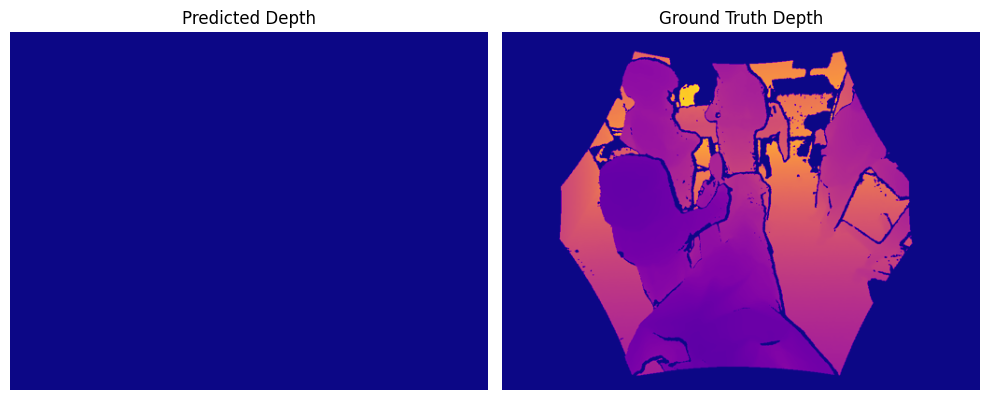

In [11]:
from matplotlib import pyplot as plt
fig, axes = plt.subplots(1, 2, figsize=(10, 6))

axes[0].imshow(depth.cpu().numpy(), cmap='plasma')
axes[0].set_title('Predicted Depth')
axes[0].axis('off')

axes[1].imshow(gt_depth_image, cmap='plasma')
axes[1].set_title('Ground Truth Depth')
axes[1].axis('off')
plt.tight_layout()
plt.show()

Depth Scaling $\theta = argmin ||Y - X\theta||_2^2$

In [12]:
pos = np.where(gt_depth_image >= 100)  # 100 mm threshold
gt_y = gt_depth_image[pos][:, None] / 1000.0  # Convert to meters
x = depth.cpu().numpy()[pos][:, None]

# Linear regression to find the scale factor
scaling_factor = np.linalg.inv(x.T @ x + 0.1) @ (x.T @ gt_y)  # It is scaler so leave the np.eye
print(f'Scaling factor: {scaling_factor}')

# Apply scaling factor to the predicted depth
depth_scaled = depth.cpu().numpy() * scaling_factor[0, 0]

# Check MSE
se = (x * scaling_factor - gt_y) ** 2
mse = np.mean(se)
print(f'Mean Squared Error: {mse}')
print(f'Max Error: {se.max()}')
pos_max = se.argmax()
print(f'Max Error Position: {pos_max}, Predicted: {x[pos_max]}, GT: {gt_y[pos_max]}')

Scaling factor: [[0.]]
Mean Squared Error: 5.144297861151416
Max Error: 30.980355999999997
Max Error Position: 8606, Predicted: [0.], GT: [5.566]


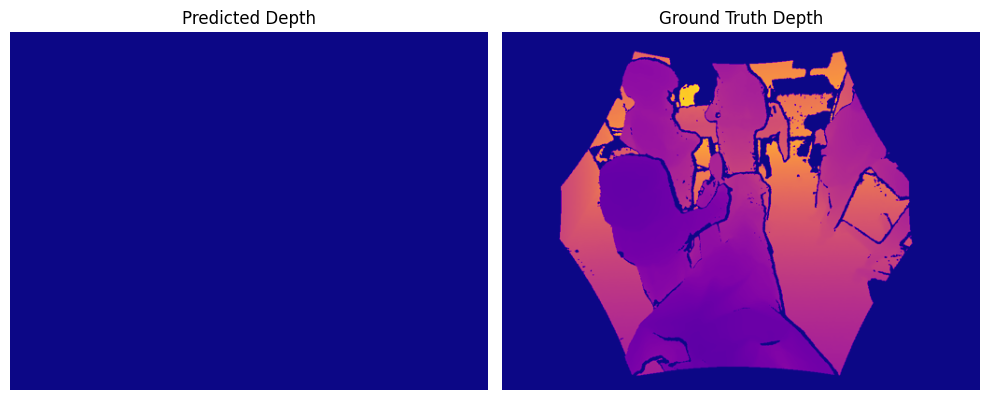

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(10, 6))

axes[0].imshow(depth_scaled, cmap='plasma')
axes[0].set_title('Predicted Depth')
axes[0].axis('off')

axes[1].imshow(gt_depth_image, cmap='plasma')
axes[1].set_title('Ground Truth Depth')
axes[1].axis('off')
plt.tight_layout()
plt.show()

Depth Prediction with Marigold

In [14]:
warnings.simplefilter(action="ignore", category=FutureWarning)
diffusers.utils.logging.disable_progress_bar()

class MarigoldDepthCompletionPipeline(MarigoldDepthPipeline):
    """
    Pipeline for Marigold Depth Completion.
    Extends the MarigoldDepthPipeline to include depth completion functionality.
    """
    def __call__(
        self, image: Image.Image, sparse_depth: np.ndarray,
        num_inference_steps: int = 50, processing_resolution: int = 768, seed: int = 2024
    ) -> np.ndarray:
        
        """
        Args:
            image (PIL.Image.Image): Input image of shape [H, W] with 3 channels.
            sparse_depth (np.ndarray): Sparse depth guidance of shape [H, W].
            num_inference_steps (int, optional): Number of denoising steps. Defaults to 50.
            processing_resolution (int, optional): Resolution for processing. Defaults to 768.
            seed (int, optional): Random seed. Defaults to 2024.

        Returns:
            np.ndarray: Dense depth prediction of shape [H, W].

        """
        # Resolving variables
        device = self._execution_device
        generator = torch.Generator(device=device).manual_seed(seed)

        # Check inputs.
        if num_inference_steps is None:
            raise ValueError("Invalid num_inference_steps")
        if type(sparse_depth) is not np.ndarray or sparse_depth.ndim != 2:
            raise ValueError("Sparse depth should be a 2D numpy ndarray with zeros at missing positions")

        # Prepare empty text conditioning
        with torch.no_grad():
            if self.empty_text_embedding is None:
                text_inputs = self.tokenizer("", padding="do_not_pad", 
                    max_length=self.tokenizer.model_max_length, truncation=True, return_tensors="pt")
                text_input_ids = text_inputs.input_ids.to(device)
                self.empty_text_embedding = self.text_encoder(text_input_ids)[0]  # [1,2,1024]

        # Preprocess input images
        image, padding, original_resolution = self.image_processor.preprocess(
            image, processing_resolution=processing_resolution, device=device, dtype=self.dtype
        )  # [N,3,PPH,PPW]

        # Check sparse depth dimensions
        if sparse_depth.shape != original_resolution:
            raise ValueError(
                f"Sparse depth dimensions ({sparse_depth.shape}) must match that of the image ({image.shape[-2:]})"
            )
        
        # Encode input image into latent space
        with torch.no_grad():
            image_latent, pred_latent = self.prepare_latents(image, None, generator, 1, 1)  # [N*E,4,h,w], [N*E,4,h,w]
        del image

        # Preprocess sparse depth
        sparse_depth = torch.from_numpy(sparse_depth)[None, None].float().to(device)
        sparse_mask = sparse_depth > 0
        logging.info(f"Using {sparse_mask.int().sum().item()} guidance points")

        # Set up optimization targets and compute the range and lower bound of the sparse depth
        scale, shift = torch.nn.Parameter(torch.ones(1, device=device)), torch.nn.Parameter(torch.ones(1, device=device))
        pred_latent = torch.nn.Parameter(pred_latent)
        sparse_range = (sparse_depth[sparse_mask].max() - sparse_depth[sparse_mask].min()).item() # (cmax − cmin)
        sparse_lower = (sparse_depth[sparse_mask].min()).item() # cmin
        
        # Set up optimizer
        optimizer = torch.optim.Adam([ {"params": [scale, shift], "lr": 0.005},
                                       {"params": [pred_latent] , "lr": 0.05 }])

        def affine_to_metric(depth: torch.Tensor) -> torch.Tensor:
            # Convert affine invariant depth predictions to metric depth predictions using the parametrized scale and shift. See Equation 2 of the paper.
            return (scale**2) * sparse_range * depth + (shift**2) * sparse_lower

        def latent_to_metric(latent: torch.Tensor) -> torch.Tensor:
            # Decode latent to affine invariant depth predictions and subsequently to metric depth predictions.
            affine_invariant_prediction = self.decode_prediction(latent)  # [E,1,PPH,PPW]
            prediction = affine_to_metric(affine_invariant_prediction)
            prediction = self.image_processor.unpad_image(prediction, padding)  # [E,1,PH,PW]
            prediction = self.image_processor.resize_antialias(
                prediction, original_resolution, "bilinear", is_aa=False
            )  # [1,1,H,W]
            return prediction

        def loss_l1l2(input: torch.Tensor, target: torch.Tensor) -> torch.Tensor:
            # Compute L1 and L2 loss between input and target.
            out_l1 = torch.nn.functional.l1_loss(input, target)
            out_l2 = torch.nn.functional.mse_loss(input, target)
            out = out_l1 + out_l2
            return out

        # Denoising loop
        self.scheduler.set_timesteps(num_inference_steps, device=device)
        for _, t in enumerate(
            self.progress_bar(self.scheduler.timesteps, desc=f"Marigold-DC steps ({str(device)})...")
        ):
            optimizer.zero_grad()

            # Forward pass through the U-Net
            batch_latent = torch.cat([image_latent, pred_latent], dim=1)  # [1,8,h,w]
            noise = self.unet(
                batch_latent, t, encoder_hidden_states=self.empty_text_embedding, return_dict=False
            )[0]  # [1,4,h,w]

            # Compute pred_epsilon to later rescale the depth latent gradient
            with torch.no_grad():
                alpha_prod_t = self.scheduler.alphas_cumprod[t]
                beta_prod_t = 1 - alpha_prod_t
                pred_epsilon = (alpha_prod_t**0.5) * noise + (beta_prod_t**0.5) * pred_latent

            step_output = self.scheduler.step(noise, t, pred_latent, generator=generator)

            # Preview the final output depth with Tweedie's formula (See Equation 1 of the paper)
            pred_original_sample = step_output.pred_original_sample

            # Decode to metric space, compute loss with guidance and backpropagate
            current_metric_estimate = latent_to_metric(pred_original_sample)
            loss = loss_l1l2(current_metric_estimate[sparse_mask], sparse_depth[sparse_mask])
            loss.backward()

            # Scale gradients up
            with torch.no_grad():
                pred_epsilon_norm = torch.linalg.norm(pred_epsilon).item()
                depth_latent_grad_norm = torch.linalg.norm(pred_latent.grad).item()
                scaling_factor = pred_epsilon_norm / max(depth_latent_grad_norm, 1e-8)
                pred_latent.grad *= scaling_factor

            # Execute the update step through guidance backprop
            optimizer.step()

            # Execute update of the latent with regular denoising diffusion step
            with torch.no_grad():
                pred_latent.data = self.scheduler.step(noise, t, pred_latent, generator=generator).prev_sample

            del pred_original_sample, current_metric_estimate, step_output, pred_epsilon, noise
            torch.cuda.empty_cache()

        del image_latent

        # Decode predictions from latent into pixel space
        with torch.no_grad():
            prediction = latent_to_metric(pred_latent.detach())

        # return Numpy array
        prediction = self.image_processor.pt_to_numpy(prediction)  # [N,H,W,1]
        self.maybe_free_model_hooks()

        return prediction.squeeze()


In [22]:
DEPTH_CHECKPOINT = "prs-eth/marigold-depth-v1-0"
num_inference_steps = 50
processing_resolution = 768

if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    if torch.backends.mps.is_available():
        device = torch.device("mps")
    else:
        device = torch.device("cpu")
    processing_resolution_non_cuda = 512
    num_inference_steps_non_cuda = 10
    if processing_resolution > processing_resolution_non_cuda:
        logging.warning(f"CUDA not found: Reducing processing_resolution to {processing_resolution_non_cuda}")
        processing_resolution = processing_resolution_non_cuda
    if num_inference_steps > num_inference_steps_non_cuda:
        logging.warning(f"CUDA not found: Reducing num_inference_steps to {num_inference_steps_non_cuda}")
        num_inference_steps = num_inference_steps_non_cuda

pipe = MarigoldDepthCompletionPipeline.from_pretrained(DEPTH_CHECKPOINT, prediction_type="depth").to(device)
pipe.scheduler = DDIMScheduler.from_config(pipe.scheduler.config, timestep_spacing="trailing")

if not torch.cuda.is_available():
    logging.warning("CUDA not found: Using a lightweight VAE")
    del pipe.vae
    pipe.vae = diffusers.AutoencoderTiny.from_pretrained("madebyollin/taesd").to(device)

pred = pipe(
    image=image_cropped,
    sparse_depth=gt_depth_image / 1000.0,
    num_inference_steps=num_inference_steps,
    processing_resolution=processing_resolution,
)

Marigold-DC steps (cuda:0)...: 100%|██████████| 50/50 [00:58<00:00,  1.17s/it]


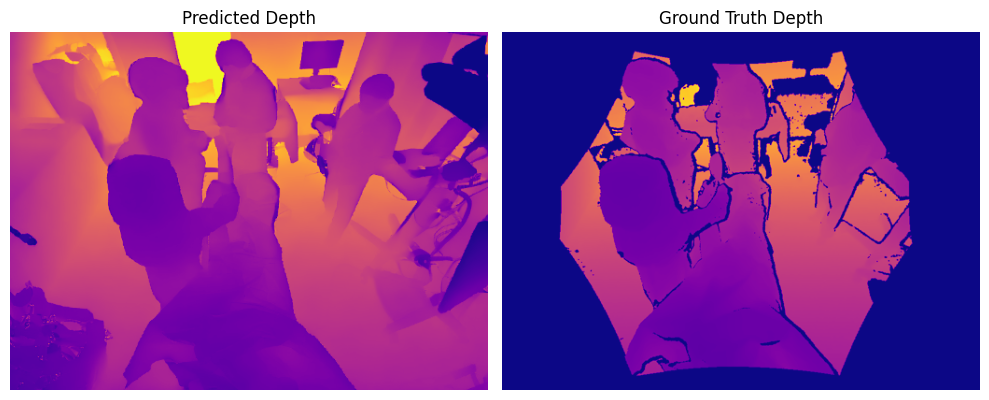

In [23]:
fig, axes = plt.subplots(1, 2, figsize=(10, 6))

axes[0].imshow(pred, cmap='plasma')
axes[0].set_title('Predicted Depth')
axes[0].axis('off')

axes[1].imshow(gt_depth_image, cmap='plasma')
axes[1].set_title('Ground Truth Depth')
axes[1].axis('off')
plt.tight_layout()
plt.show()

In [24]:
pos = np.where(gt_depth_image >= 100)  # 100 mm threshold
gt_y = gt_depth_image[pos][:, None] / 1000.0  # Convert to meters
x = pred[pos][:, None]

# Linear regression to find the scale factor
scaling_factor = np.linalg.inv(x.T @ x + 0.1) @ (x.T @ gt_y)  # It is scaler so leave the np.eye
print(f'Scaling factor: {scaling_factor}')

# Apply scaling factor to the predicted depth
pred_scaled = pred * scaling_factor[0, 0]

# Check MSE
se = (x * scaling_factor - gt_y) ** 2
mse = np.mean(se)
print(f'Mean Squared Error: {mse}')
print(f'Max Error: {se.max()}')
pos_max = se.argmax()
print(f'Max Error Position: {pos_max}, Predicted: {x[pos_max]}, GT: {gt_y[pos_max]}')

Scaling factor: [[0.98035505]]
Mean Squared Error: 0.16980347229560305
Max Error: 22.59695569825667
Max Error Position: 7037, Predicted: [4.995767], GT: [0.144]
